In [1]:
import sys
sys.path.append('..')
# from src.evo_eq_model import *
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
%load_ext autoreload

In [3]:
import random
import numpy.random as rnd
# import networkx as nx
# from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import re
import neo_originations.utils as ut
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so
import scipy.stats as spst

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
sns.set_theme(context='poster')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 15
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30

2024-12-10 17:16:24.437 | INFO     | neo_originations.config:<module>:11 - PROJ_ROOT path is: /Users/dennytrimcev/Dropbox/Work_Main/Thesis/2_chapter


In [4]:
from pandarallel import pandarallel
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
flupredict_to_pango = {"1":"WT",
            "1A":"A",
            "1B":"B",
            "1C":"B.1",
            "1C.2A":"B.1",
            "1C.2A.3A":"B.1",
            "1C.2A.3A.4A":"B.1.427/429",
            "1C.2A.3A.4B":"B.1.351",
            '1C.2A.3A.4C':"B.1.526",
            "1C.2B":"B1.1",
            "1C.2B.3D":"B.1.1.7",
            "1C.2B.3G":"P.1",
            "1C.2B.3J":"BA",
            "1C.2B.3J.4D":"BA.1",
            "1C.2B.3J.4D.5A":"BA.1.1",
            "1C.2B.3J.4E":"BA.2",
            "1C.2B.3J.4E.5B": "BA.2.12.1",
            "1C.2B.3J.4E.5C":"BA.2.75",
            "1C.2B.3J.4E.5C.6A":"BA.2.75.2",
            "1C.2B.3J.4E.5C.6E":"BM.1.1",
            "1C.2B.3J.4E.5C.6I.7C":"CH.1.1",
            "1C.2B.3J.4E.5C.6F":"BN.1",
            "1C.2B.3J.4E.5O":"BA.2.86",
            "1C.2B.3J.4E.5O.6L":"JN.1",
            "1C.2B.3J.4E.5O.6L.7G":"JN.1.1",
            "1C.2B.3J.4E.5O.6L.7H":"JN.1.4",
            "1C.2B.3J.4E.5O.6L.7I":"JN.1.11",
            "1C.2B.3J.4F":"BA.4",
            "1C.2B.3J.4F.5D":"BA.4.6",
            "1C.2B.3J.4G":"BA.5",
            "1C.2B.3J.4G.5E":"BF.7",
            "1C.2B.3J.4G.5F":"BQ.1",
            "1C.2B.3J.4G.5F.6B":"BQ.1.1",
            "1C.2C":"B.1.177",
            "1C.2D":"B.1.1",
            "1C.2D.3E":"B.1.617.1",
            "1C.2D.3F":"B.1.617.2",
            "1C.2A.3I":"B.1.621",
            "1C.2B.3J.4E.5N":"XBB",
            "1C.2B.3J.4E.5N.6J":"XBB.1.5",
            "1C.2B.3J.4E.5N.6J.7F":"JD.1.1",
            "1C.2B.3J.4E.5N.6J.7D":"XBB.1.9",
            "1C.2B.3J.4E.5N.6J.7D.8A":"EG.5.1",
            "1C.2B.3J.4E.5N.6J.7D.8A.9A":"HK.3",
            "1C.2B.3J.4E.5N.6J.7D.8A.9B":"HV.1",
            "1C.2B.3J.4E.5N.6J.7E":"XBB.1.16",
            "1C.2B.3J.4E.5N.6K":"XBB.2.3"}

In [6]:
# home = os.path.expanduser("~")
# project_path =  os.path.relpath("..")
# if project_path not in sys.path:
#     sys.path.append(project_path)

# sys.path.insert(1, project_path)

# output_folder= project_path+'/report/figures/'
# os.makedirs(output_folder, exist_ok = True)
# data_folder = project_path+'/data/'
# new_data_folder = project_path+'/new_data/'
# saves_folder= project_path + '/saves/'
# self_generated_data = project_path + '/self_generated_data/'

In [7]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)

output_folder= project_path+'/reports/figures/'
os.makedirs(output_folder, exist_ok = True)
data_folder = project_path+'/data/'
saves_folder= project_path + '/data/interim/'
self_generated_data = project_path + '/data/processed/'

# thesis_picture_folder = os.path.relpath("../../Thesis/figures/2_chapter/")
# assert os.path.exists(thesis_picture_folder)

In [8]:
syn_gene_info = pd.read_feather(saves_folder+'2024-08-saves/syn_gene_info.feather')

In [9]:
# global_clade_stats_SARS_CoV_2_folder = project_path+'/data/global_clade_stats_SARS_CoV_2/'
global_clade_stats_SARS_CoV_2_folder = project_path+'/data/external/2024-08-05-data/'

assert os.path.exists(global_clade_stats_SARS_CoV_2_folder)

global_clade_statistics_SARS_CoV_2_World = pd.read_csv(global_clade_stats_SARS_CoV_2_folder+'/clade_statistics.tsv', sep = '\t')

global_clade_statistics_SARS_CoV_2_World = global_clade_statistics_SARS_CoV_2_World#.query(f'Time < "{last_date}"')

driver_mutation_statistics = pd.read_csv(global_clade_stats_SARS_CoV_2_folder+'/driver_mutation_statistics.tsv', sep = '\t')


reference_date = pd.to_datetime('2020-01-01')
global_clade_statistics_SARS_CoV_2_World['day_diff'] = (pd.to_datetime(global_clade_statistics_SARS_CoV_2_World['Time']) - reference_date).dt.days

In [10]:
driver_mutation_statistics['Pango_Variant'] = driver_mutation_statistics['Variant'].map(flupredict_to_pango)

syn_set = set([c for c in driver_mutation_statistics.columns if 'syn' in c]) - set([c for c in driver_mutation_statistics.columns if 'RBD' in c or 'weight' in c])
nonsyn_set = [c.split('_')[1] for c in syn_set if 'syn' in c]

driver_mutation_statistics['syn_weight'] = driver_mutation_statistics.apply(lambda x: np.sum([x[gene] for gene in syn_set]), axis=1)
driver_mutation_statistics['nonsyn_weight'] = driver_mutation_statistics.apply(lambda x: np.sum([x[gene] for gene in nonsyn_set]), axis=1)
driver_mutation_statistics['total_weight'] = driver_mutation_statistics.apply(lambda x: x['syn_weight']+x['nonsyn_weight'], axis=1)

In [11]:
L_syn = 1e4

global_clade_statistics_SARS_CoV_2_World = pd.merge(global_clade_statistics_SARS_CoV_2_World, driver_mutation_statistics[['Clade','syn_weight','total_weight']], on = 'Clade', how = 'left')

global_clade_statistics_SARS_CoV_2_World['local_diversity'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*(1-global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq'])*(global_clade_statistics_SARS_CoV_2_World['syn_weight'])

global_clade_statistics_SARS_CoV_2_World['total_local_diversity'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*(1-global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq'])*(global_clade_statistics_SARS_CoV_2_World['total_weight'])

global_clade_statistics_SARS_CoV_2_World['weighted_freq'] = global_clade_statistics_SARS_CoV_2_World['Sublineage_Freq']*global_clade_statistics_SARS_CoV_2_World['syn_weight']

average_diversity = global_clade_statistics_SARS_CoV_2_World.groupby('day_diff').agg({'local_diversity':'sum', 'weighted_freq':'sum', 'total_local_diversity':'sum'}).reset_index()
average_diversity['diversity'] = average_diversity['local_diversity']/L_syn
average_diversity['total_diversity'] = average_diversity['total_local_diversity']/3e4
average_diversity['avg_freq'] = average_diversity['weighted_freq']/L_syn

In [12]:
last_date = '2022-12-31'
#/Users/dennytrimcev/Dropbox/Work_Main/neo_originations/data/external/2024-03-04-data
covid_data = pd.read_csv(project_path+'/data/external/2024-03-04-data/covid_data.csv')
covid_data_World  = covid_data[covid_data['location'] == 'World']#.query(f'date < "{last_date}"')

covid_data_World['day_diff'] = (pd.to_datetime(covid_data_World['date']) - reference_date).dt.days

In [13]:
saves_folder

'../data/interim/'

In [14]:
clade_names = pd.read_feather(saves_folder + '2024-08-04-saves/clade_names.feather')

In [15]:
def diversity_without_most_diverse_sites(variant_freq_arr, n_sites = 30, t_dimension = 1):
    L_dimension = 2 if t_dimension == 1 else 1

    most_diverse_sites = np.argsort(np.average(np.sum(variant_freq_arr*(1-variant_freq_arr), axis = 0), axis = t_dimension))[-n_sites:]
    
    full_index = np.arange(0, variant_freq_arr.shape[L_dimension])
    index_without_most_diverse = np.setdiff1d(full_index, most_diverse_sites)

    variant_div_without_most_diverse = np.sum(np.sum(variant_freq_arr[:,index_without_most_diverse,:]*(1-variant_freq_arr[:,index_without_most_diverse,:]), axis = 0), axis = L_dimension-1)/len(full_index)
    variant_div_most_diverse = np.sum(np.sum(variant_freq_arr[:,most_diverse_sites,:]*(1-variant_freq_arr[:,most_diverse_sites,:]), axis = 0), axis = L_dimension-1)/len(full_index)

    return variant_div_without_most_diverse, variant_div_most_diverse

In [16]:

# freq_arr_var_files = {c:np.load(self_generated_data + f'2024-8-9-freq_big_arr_0var/freq_big_arr_0{c}.npz', allow_pickle = True) for c in clade_names.name.values}
# freq_arrs_var_dict = {c: freq_arr_var_files[c]['freq_big_arr'] for c in tqdm(clade_names.name.values)}
# time_arrs_var_dict = {c: freq_arr_var_files[c]['time_inds'] for c in clade_names.name.values}

In [17]:
div_saves_folder = self_generated_data+'2024-11-08_saves/'

In [18]:
least_diverse_div_dict = {}
most_diverse_div_dict = {} 
total_div_dict = {} 
# least_diverse_div_dict = {c:
#                     np.load(div_saves_folder + f'/least_diverse_div_{c}.npz', allow_pickle = True) for c in clade_names.name.values}
for c in clade_names.name.values:
    try:
        least_diverse_div_dict[c]  =np.load(div_saves_folder + f'/least_diverse_div_{c}.npz', allow_pickle = True)['div_arr_i']
        most_diverse_div_dict[c] = np.load(div_saves_folder + f'/most_diverse_div_{c}.npz', allow_pickle = True)['div_arr_i']
        total_div_dict[c] = np.load(div_saves_folder + f'/total_div_arr_{c}.npz', allow_pickle = True)['div_arr_i']
    except Exception as e:
        pass


100%|██████████| 34/34 [00:00<00:00, 1271.68it/s]


'BA.2.86'
'B.N.1'
'BA.4.6'
'BF.7'
'CH.1.1'
'JN.1'
'JN.1.1'
'BQ.1'
'JN.1.16'
'JN.1.4'
'JN.1.16.1'
'KP.2'
'LB.1'
'KP.2.3'
'KP.1.1'
'KP.3'
'BQ.1.1'
'HK.3'
'HV.1'
'JD.1.1'


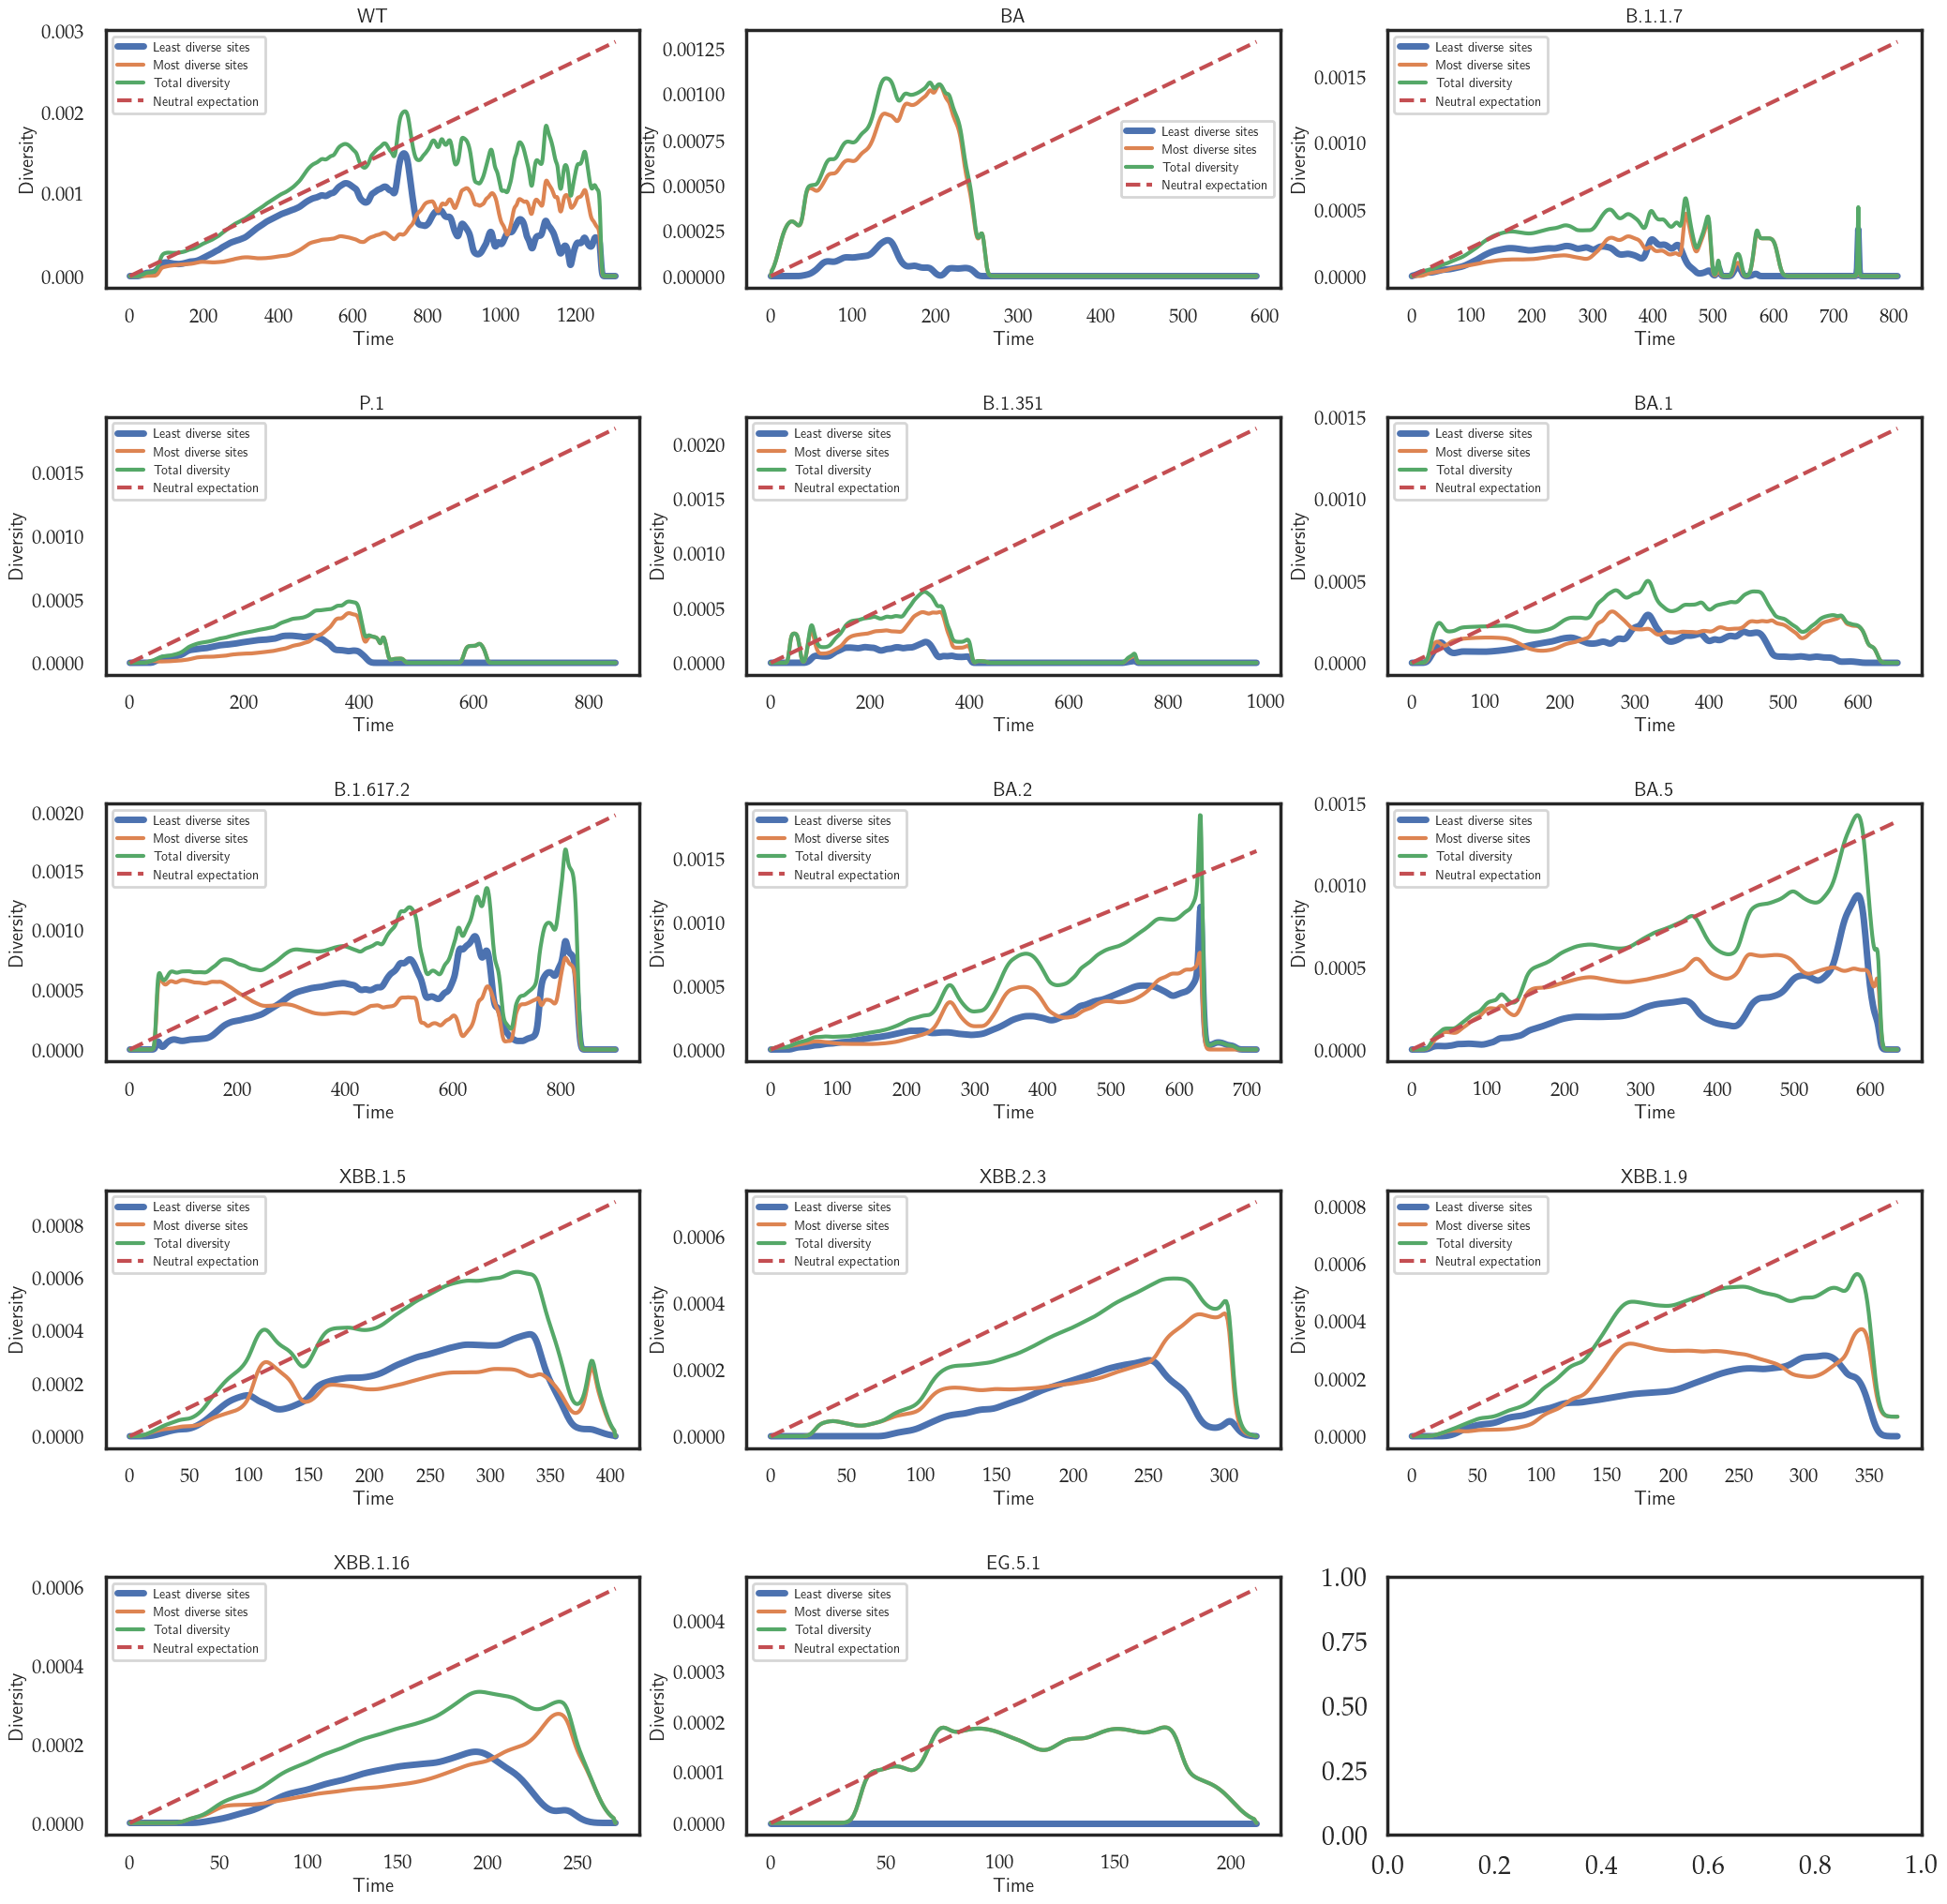

In [19]:
u = 8e-4/(52*7)

fig,ax = plt.subplots(5,3, figsize = (25,25))
ax = ax.flatten()
plt.subplots_adjust(hspace = 0.5)
i=0
for vstring in tqdm(clade_names.name.values):
    try:
        
        totdiv = total_div_dict[vstring]
        div = least_diverse_div_dict[vstring]
        div_most_diverse_sites = most_diverse_div_dict[vstring]
        
        ax[i].plot(np.arange(0, len(div)), div, label = 'Least diverse sites',lw=5)
        ax[i].plot(np.arange(0, len(div_most_diverse_sites)), div_most_diverse_sites, label = 'Most diverse sites')
        ax[i].plot(np.arange(0, len(totdiv)), totdiv, label = 'Total diversity')
        ax[i].plot(np.arange(0, len(div)), u*np.arange(0, len(div)), label = 'Neutral expectation', ls = '--')
        ax[i].legend(fontsize=10)
        ax[i].set_title(vstring, fontsize= 15)
        ax[i].set_xlabel('Time', fontsize= 15)
        ax[i].set_ylabel('Diversity', fontsize= 15)
        ax[i].tick_params(axis='both', which='major', labelsize=15)
        
        i+=1
    except Exception as e:
        print(e)
        continue
    # fig,ax = plt.subplots(1,1, figsize = (20,10))
    # totdiv = total_div_dict[vstring]
    # div = least_diverse_div_dict[vstring]
    # div_most_diverse_sites = most_diverse_div_dict[vstring]
    # ax[i].plot(np.arange(0, len(div)), div, label = 'Least diverse sites',lw=5)
    # ax[i].plot(np.arange(0, len(div_most_diverse_sites)), div_most_diverse_sites, label = 'Most diverse sites')
    # ax[i].plot(np.arange(0, len(totdiv)), totdiv, label = 'Total diversity')
    # ax[i].plot(np.arange(0, len(div)), u*np.arange(0, len(div)), label = 'Neutral expectation', ls = '--')


In [20]:
self_generated_data

'../data/processed/'

In [21]:
to_clean = ['B.1.617.2','XBB.1.9','XBB.1.5','BA']

100%|██████████| 34/34 [00:00<00:00, 3966.36it/s]


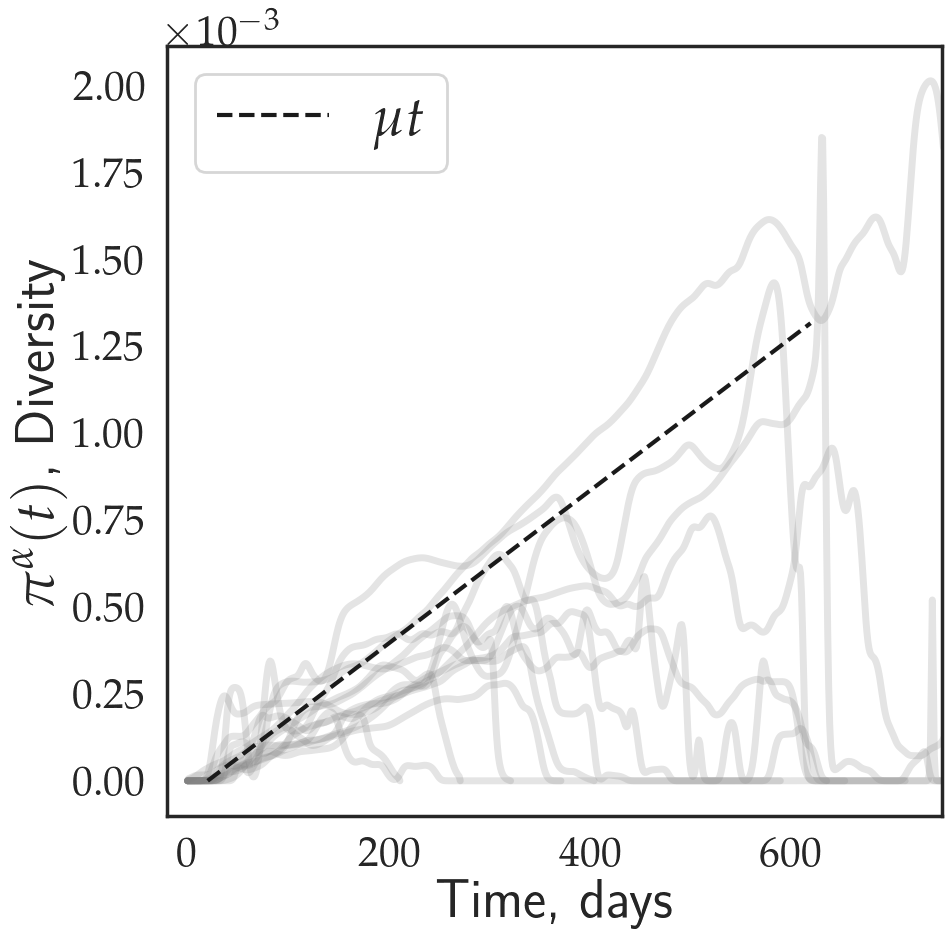

In [22]:
u = 8e-4/52
u_days = 8e-4/(52*7)
fig,ax = plt.subplots(1,1, figsize = (10,10))
for vstring in tqdm(clade_names.name.values):
    try:
        
        # totdiv = total_div_dict[vstring]
        div = least_diverse_div_dict[vstring] if vstring in to_clean else total_div_dict[vstring]
        div_most_diverse_sites = most_diverse_div_dict[vstring]
        
        
        ax.plot(np.arange(0, len(div)), div ,lw=5,color='grey',alpha=.21)
        
    except Exception as e:
        # print(e)
        continue
# ax.plot(np.arange(0, len(div_most_diverse_sites)), div_most_diverse_sites, label = 'Most diverse sites')
# ax.plot(np.arange(0, len(totdiv)), totdiv, label = 'Total diversity')

ax.plot(20+np.arange(0, 600), u_days*np.arange(0, 600), ls = '--',color='k',label = r'$\mu t$')

# ax.legend()
# ax.set_title(vstring)
ax.set_xlabel('Time, days',fontsize=40)
ax.set_ylabel(r'$\pi^\alpha(t)$, Diversity',fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
offset_text = ax.yaxis.get_offset_text()
offset_text.set_fontsize(30)
offset_text.set_position((offset_text.get_position()[0], offset_text.get_position()[1] + 2.3))

ax.set_xlim(-20,750)
ax.legend(fontsize=40)

# plt.savefig(thesis_picture_folder + '/diversities_against_mu_t.pdf',bbox_inches='tight')